In [1]:
#!pip install spacy
#!pip install nltk
#!pip install wordcloud
#nltk.download('stopwords')
#!pip install TextBlob
#nltk.download('wordnet')
#nltk.download('punkt')
#!pip install pyLDAvis
#!pip install --upgrade ipykernel

In [146]:
# https://www.kaggle.com/jiashenliu/515k-hotel-reviews-data-in-europe

# Environment
import os

# Random
import random
random.seed(2)

# Data Manipulation Tools
import pandas as pd
import numpy as np
from fuzzymatcher import link_table, fuzzy_left_join
import difflib 
import geopandas as gpd
pd.options.display.max_rows = 1000
pd.options.display.max_columns = 100


# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

# Data Visualization Tools
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from colour import Color
%matplotlib inline
plt.style.use('bmh')
from nltk import sent_tokenize
from math import pi

# libraries for displaying images
from IPython.display import HTML, Image 
from IPython.core.display import HTML 
from IPython.display import display
import selenium

# NLP Module
import nltk # Natural language processing toolkit
from nltk import FreqDist # Frequency distribution
import re # for regular expressions
import spacy # library for advanced Natural Language Processing 
from nltk.corpus import stopwords
from wordcloud import WordCloud,STOPWORDS 
from textblob import TextBlob
from nltk.stem import WordNetLemmatizer 

# network
from nltk import bigrams, ngrams
import networkx as nx 
import itertools
import collections


# Location Modules
import folium
from geopy.geocoders import Nominatim

# Web Scraping Modules
import requests 
from bs4 import BeautifulSoup as bs
from io import StringIO

# Securing Credentials
import getpass

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category= DeprecationWarning)

In [174]:
#df = pd.read_csv('Hotel_Reviews.csv')

df = pd.read_csv('Hotel_Reviews.csv')
print(df.shape)
df.head(2)

(515738, 17)


,Hotel_Address,Additional_Number_of_Scoring,Review_Date,Average_Score,Hotel_Name,Reviewer_Nationality,Negative_Review,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Positive_Review,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,Tags,days_since_review,lat,lng
0,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,8/3/2017,7.7,Hotel Arena,Russia,I am so angry that i made this post available...,397,1403,Only the park outside of the hotel was beauti...,11,7,2.9,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,52.360576,4.915968
1,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,8/3/2017,7.7,Hotel Arena,Ireland,No Negative,0,1403,No real complaints the hotel was great great ...,105,7,7.5,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,52.360576,4.915968


In [175]:
df.dtypes

Hotel_Address                                  object
Additional_Number_of_Scoring                    int64
Review_Date                                    object
Average_Score                                 float64
Hotel_Name                                     object
Reviewer_Nationality                           object
Negative_Review                                object
Review_Total_Negative_Word_Counts               int64
Total_Number_of_Reviews                         int64
Positive_Review                                object
Review_Total_Positive_Word_Counts               int64
Total_Number_of_Reviews_Reviewer_Has_Given      int64
Reviewer_Score                                float64
Tags                                           object
days_since_review                              object
lat                                           float64
lng                                           float64
dtype: object

<AxesSubplot:>

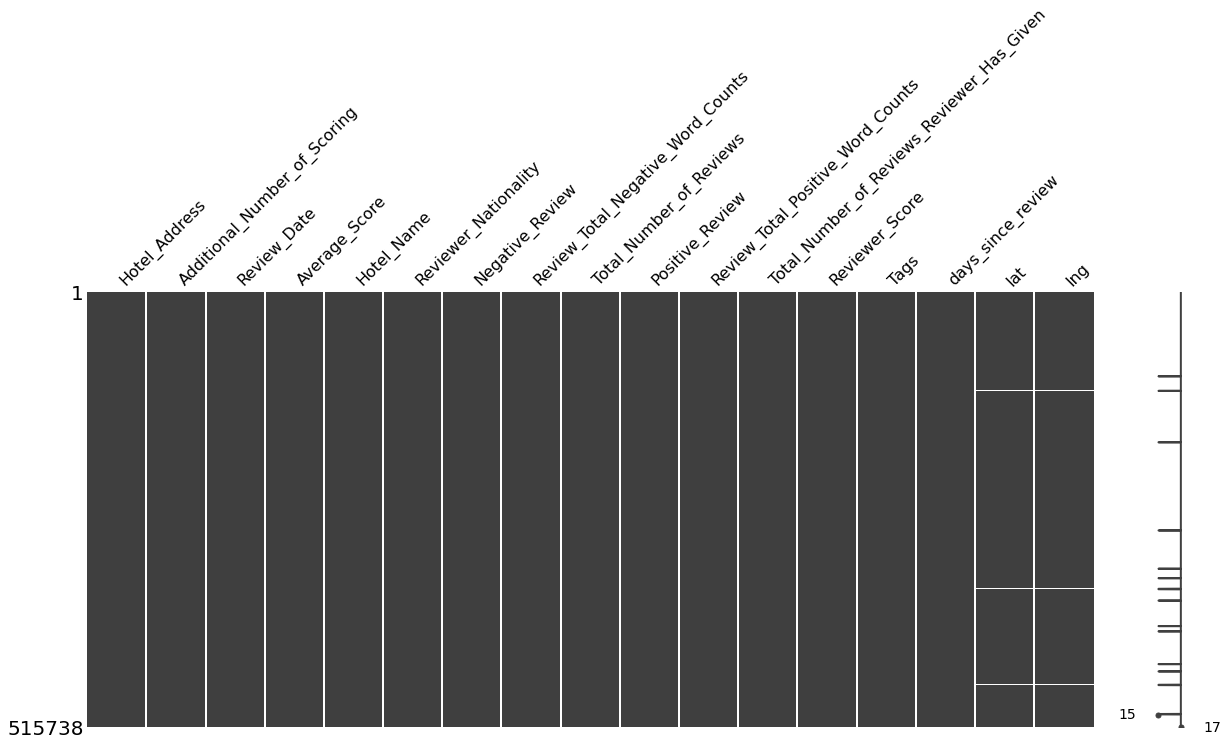

In [176]:
import missingno as msno
msno.matrix(df, figsize = (20,8))

In [177]:
df.isnull().sum()

Hotel_Address                                    0
Additional_Number_of_Scoring                     0
Review_Date                                      0
Average_Score                                    0
Hotel_Name                                       0
Reviewer_Nationality                             0
Negative_Review                                  0
Review_Total_Negative_Word_Counts                0
Total_Number_of_Reviews                          0
Positive_Review                                  0
Review_Total_Positive_Word_Counts                0
Total_Number_of_Reviews_Reviewer_Has_Given       0
Reviewer_Score                                   0
Tags                                             0
days_since_review                                0
lat                                           3268
lng                                           3268
dtype: int64

In [178]:
# see how many hotel and reviews each hotel
df.groupby(['Hotel_Name']).count().sort_values('Review_Date', ascending = False)['Review_Date']

Hotel_Name
Britannia International Hotel Canary Wharf           4789
Strand Palace Hotel                                  4256
Park Plaza Westminster Bridge London                 4169
Copthorne Tara Hotel London Kensington               3578
DoubleTree by Hilton Hotel London Tower of London    3212
                                                     ... 
Hotel Eitlj rg                                         12
Le Lavoisier                                           12
Hotel Wagner                                           10
Mercure Paris Porte d Orleans                          10
Hotel Gallitzinberg                                     8
Name: Review_Date, Length: 1492, dtype: int64

In [179]:
# drop null coordinates
df.dropna(inplace = True)

In [180]:
# replace No Negative and No Positive with empty string

df['Negative_Review'] = df['Negative_Review'].replace({'No Negative': ''})
df['Positive_Review'] = df['Positive_Review'].replace({'No Positive': ''})

In [181]:
len(df.Hotel_Name.unique()) #total number of distinct hotels

1475

Text(0, 0.5, 'Score Counts')

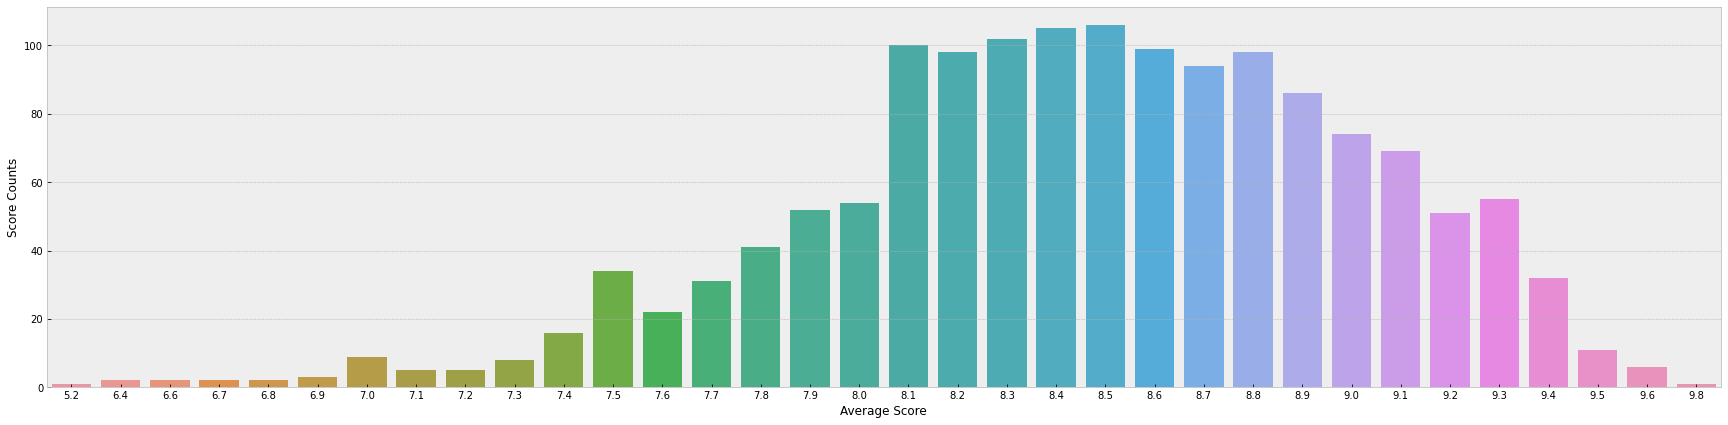

In [11]:
# Plot average score

data_plot = df[["Hotel_Name","Average_Score"]].drop_duplicates()
fig, ax = plt.subplots(figsize= (30,7))
sns.countplot(ax = ax,x = "Average_Score",data=data_plot)
ax.set_xlabel('Average Score')
ax.set_ylabel('Score Counts')

In [12]:
# A function to remove stopwords
def remove_stopwords(rev):
    rev_new = " ".join([i for i in rev if i not in stop_words])
    return rev_new

# A function to count the most frequent words
def freq_words(x, terms = 30):
    all_words = ' '.join([text for text in x])
    all_words = all_words.split()

    fdist = FreqDist(all_words)
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

    # selecting top 20 most frequent words
    d = words_df.nlargest(columns="count", n = terms) 
    plt.figure(figsize=(20,5))
    ax = sns.barplot(data=d, x= "word", y = "count")
    ax.set(ylabel = 'Count')
    plt.xticks(rotation = 90)
    plt.show()

# A function to draw word cloud
def wordcloud_draw(data, color = 'black'):
    words = ' '.join(data)
    cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and not word.startswith('#')
                                and word != 'RT'
                            ])
    wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color=color,
                      width=2500,
                      height=2000
                     ).generate(cleaned_word)
    plt.figure(1,figsize=(13, 13))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()
    
# Create a function to get the subjectivity
def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity

# Create a function to get the polarity
def getPolarity(text):
    return TextBlob(text).sentiment.polarity

In [13]:
df_reviews = df[['Hotel_Name', 'Negative_Review', 'Positive_Review']]
df_reviews.head()

# Define stopwords
stop_words = stopwords.words('english')

# make entire text lowercase
df_reviews['Positive_Review'] = [r.lower() for r in df_reviews['Positive_Review']] 
df_reviews['Negative_Review'] = [r.lower() for r in df_reviews['Negative_Review']]

# Remove unwanted characters, numbers and symbols
df_reviews['Positive_Review'] = df_reviews['Positive_Review'].str.replace("[^a-zA-Z#]", " ")
df_reviews['Negative_Review'] = df_reviews['Negative_Review'].str.replace("[^a-zA-Z#]", " ")

# remove short words (length < 4)
df_reviews['Positive_Review'] = df_reviews['Positive_Review'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))
df_reviews['Negative_Review'] = df_reviews['Negative_Review'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

# Lemmatizing 
lemmatizer = WordNetLemmatizer() 
df_reviews['Positive_Review'] = [' '.join([lemmatizer.lemmatize(word) for word in r.split(' ')]) for r in df_reviews['Positive_Review']]
df_reviews['Negative_Review'] = [' '.join([lemmatizer.lemmatize(word) for word in r.split(' ')]) for r in df_reviews['Negative_Review']]

# remove stopwords from the text
df_reviews['Positive_Review'] = [remove_stopwords(r.split()) for r in df_reviews['Positive_Review']]
df_reviews['Negative_Review'] = [remove_stopwords(r.split()) for r in df_reviews['Negative_Review']]


# Tokenization
df_reviews['Positive_Review'] = [r.split() for r in df_reviews['Positive_Review']]
df_reviews['Negative_Review'] = [r.split() for r in df_reviews['Negative_Review']]

In [14]:
pos = []
neg = []
_ = [[pos.append(z) for z in i] for i in df_reviews['Positive_Review']]
_ = [[neg.append(z) for z in i] for i in df_reviews['Negative_Review']]

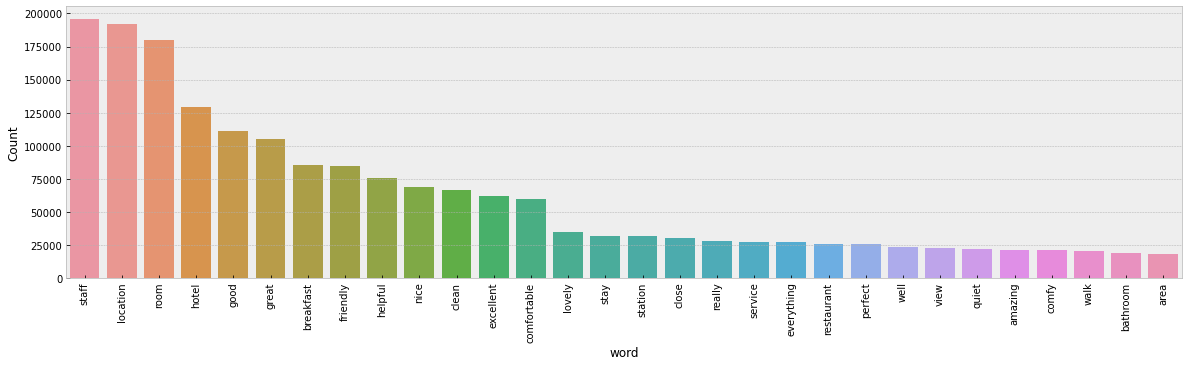

In [15]:

freq_words(pos, 30) # Frequency distribution of common words in positive reviews

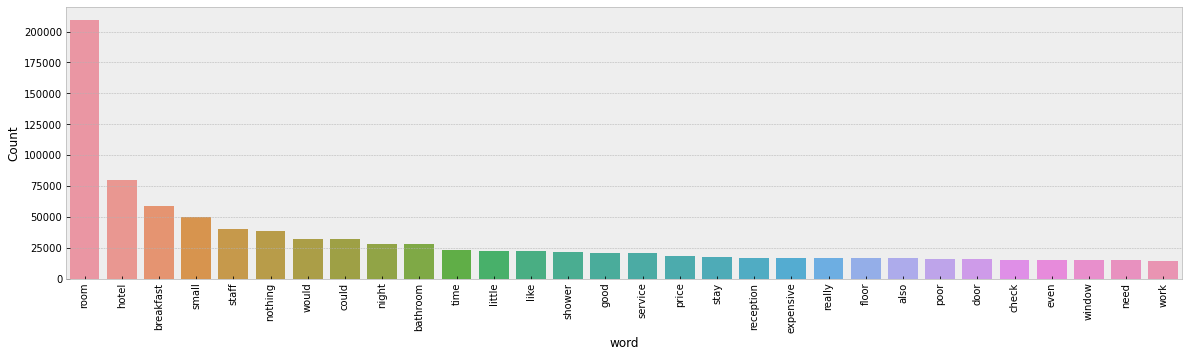

In [16]:
freq_words(neg, 30) # Checking frequency of most used words in negative reviews

Positive reviews


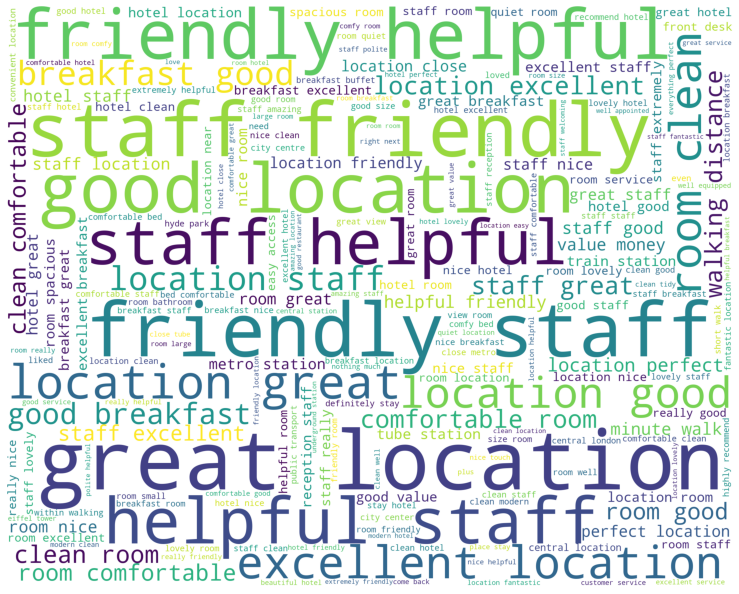

Negative reviews


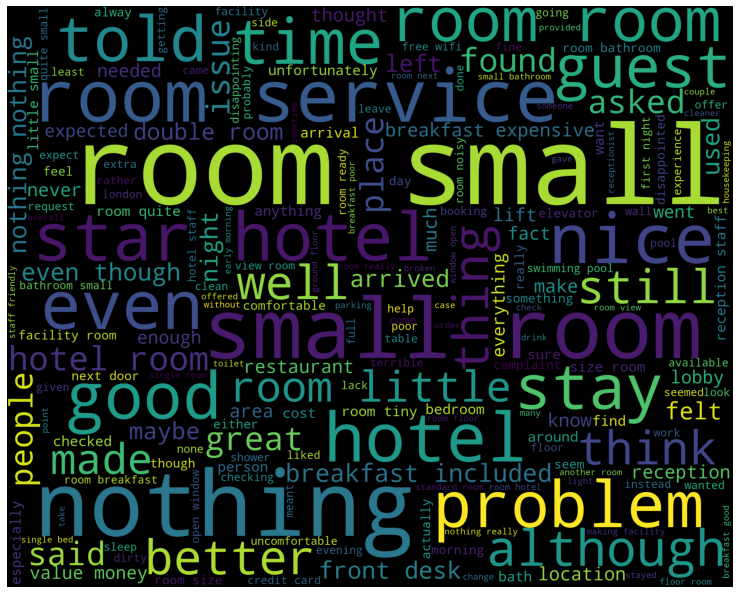

In [17]:
# Using wordcloud to visually represent the text data

print("Positive reviews")
wordcloud_draw(pos,'white')
print("Negative reviews")
wordcloud_draw(neg)

In [18]:
import gensim
from gensim.utils import simple_preprocess
LDA = gensim.models.ldamodel.LdaModel

In [19]:
import gensim.corpora as corpora
# Create Dictionary
id2word_pos = corpora.Dictionary(df_reviews['Positive_Review'])
id2word_neg = corpora.Dictionary(df_reviews['Negative_Review'])
# Create Corpus
texts_pos = df_reviews['Positive_Review']
texts_neg = df_reviews['Negative_Review']
# Term Document Frequency
corpus_pos = [id2word_pos.doc2bow(text) for text in texts_pos]
corpus_neg = [id2word_neg.doc2bow(text) for text in texts_neg]

In [20]:
from pprint import pprint
# number of topics
num_topics = 10
# Build LDA model
lda_model_pos = gensim.models.LdaMulticore(corpus=corpus_pos,
                                       id2word=id2word_pos,
                                       num_topics=num_topics)

lda_model_neg = gensim.models.LdaMulticore(corpus=corpus_neg,
                                       id2word=id2word_neg,
                                       num_topics=num_topics)
# Print the Keyword in the 10 topics
pprint(lda_model_pos.print_topics())
#doc_lda = lda_model_pos[corpus_pos]

[(0,
  '0.090*"great" + 0.088*"breakfast" + 0.075*"location" + 0.060*"good" + '
  '0.049*"excellent" + 0.043*"room" + 0.040*"staff" + 0.032*"hotel" + '
  '0.023*"service" + 0.022*"clean"'),
 (1,
  '0.046*"room" + 0.027*"free" + 0.023*"view" + 0.022*"location" + '
  '0.020*"great" + 0.019*"coffee" + 0.018*"staff" + 0.016*"nice" + '
  '0.015*"hotel" + 0.012*"good"'),
 (2,
  '0.038*"staff" + 0.034*"breakfast" + 0.021*"room" + 0.013*"friendly" + '
  '0.012*"hotel" + 0.012*"helpful" + 0.012*"great" + 0.011*"check" + '
  '0.009*"birthday" + 0.009*"good"'),
 (3,
  '0.031*"walk" + 0.028*"hotel" + 0.023*"minute" + 0.023*"room" + '
  '0.019*"location" + 0.017*"area" + 0.016*"station" + 0.015*"great" + '
  '0.013*"restaurant" + 0.012*"close"'),
 (4,
  '0.090*"hotel" + 0.049*"everything" + 0.018*"stay" + 0.017*"would" + '
  '0.015*"nice" + 0.013*"best" + 0.012*"recommend" + 0.012*"fantastic" + '
  '0.012*"time" + 0.010*"like"'),
 (5,
  '0.075*"staff" + 0.030*"good" + 0.028*"room" + 0.028*"location

In [21]:
import pyLDAvis.gensim
import pickle 
import pyLDAvis
# Visualize the topics

def ldaviz(lda_model, corpus, id2word, num_topics, filename):
    pyLDAvis.enable_notebook()
    LDAvis_data_filepath = os.path.join(os.getcwd()+str(num_topics))
    # # this is a bit time consuming - make the if statement True
    # # if you want to execute visualization prep yourself
    if True:
        LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
        with open(LDAvis_data_filepath, 'wb') as f:
            pickle.dump(LDAvis_prepared, f)
    # load the pre-prepared pyLDAvis data from disk
    with open(LDAvis_data_filepath, 'rb') as f:
        LDAvis_prepared = pickle.load(f)
    return pyLDAvis.save_html(LDAvis_prepared, os.getcwd()+ '/' + filename +'.html')
    #return LDAvis_prepared


In [27]:
# Visualization for Positive Reviews
# ldaviz(lda_model_pos, corpus_pos, id2word_pos, num_topics, 'ldavizpos')

In [ ]:
#from IPython.display import HTML

#HTML(filename="ldavizpos.html")

In [28]:
# Visualization for Negative Reviews
# daviz(lda_model_neg, corpus_neg, id2word_neg, num_topics, 'ldavizneg')

In [29]:
#from IPython.display import HTML

#HTML(filename="ldavizneg.html")

In [30]:
import re

# Extract all topics from negative and positive

topics_pos = []
topics_neg = []

scores_pos = []
scores_neg = []

for pos, neg in zip(lda_model_pos.print_topics(), lda_model_neg.print_topics()):
    
    topic_pos = re.findall("(?<=\")[a-z]+(?=\")",pos[1])
    topics_pos = topics_pos + topic_pos
    
    score_pos = re.findall("\d\.\d+",pos[1])
    scores_pos = scores_pos + score_pos

    topic_neg = re.findall("(?<=\")[a-z]+(?=\")",neg[1])
    topics_neg = topics_neg + topic_neg
    
    score_neg = re.findall("\d\.\d+",pos[1])
    scores_neg = scores_neg + score_neg
    
positive_topics = pd.DataFrame({'Topics':topics_pos, 'Score':scores_pos})
positive_topics['Score'] = positive_topics['Score'].astype(float)
positive_topics = positive_topics.groupby('Topics').sum().reset_index()\
.sort_values('Score',ascending = False)

negative_topics = pd.DataFrame({'Topics':topics_neg, 'Score':scores_neg})
negative_topics['Score'] = negative_topics['Score'].astype(float)
negative_topics = negative_topics.groupby('Topics').sum().reset_index()\
.sort_values('Score',ascending = False)

In [31]:
#inner join to see topics that belongs to each other
pd.merge(positive_topics, negative_topics, 'inner', 'Topics')

,Topics,Score_x,Score_y
0,staff,0.392,0.081
1,room,0.389,0.566
2,location,0.362,0.018
3,hotel,0.270,0.312
4,good,0.213,0.049
5,great,0.168,0.013
6,breakfast,0.164,0.115
7,friendly,0.133,0.009
8,clean,0.107,0.012
9,everything,0.049,0.028


In [32]:
# Topic labelling
aspects = ['staff', 'room', 'breakfast', 'service', 'view', 'restaurant', 'bathroom', 'pool']

In [33]:

#!pip install --upgrade ipykernel
# review teks (done) -> cleaning (done) -> topik model (done) -> analisa topik, labelkan topiknya (done) -> 
# bind tiap topik ke baris data (done) -> filter data berdasarkan topik (done)-> 
# dari masing" topik coba analisa teksnya masing", bisa pake topik model x sentiment lagi, bisa pake word correlation

# string disum tiap hotel
# next bind tiap aspek ke baris data tiap hotel
# analisis masing - masing score tiap hotel
# buat search engine untuk menampilkan lokasi, alamat, scoring aspects (termasuk overall rating)
# buat dashboard

In [34]:
df_reviews.head(2)

,Hotel_Name,Negative_Review,Positive_Review
0,Hotel Arena,"[angry, made, post, available, possible, site,...","[park, outside, hotel, beautiful]"
1,Hotel Arena,[],"[real, complaint, hotel, great, great, locatio..."


In [35]:
df_reviews = df_reviews.groupby('Hotel_Name')['Negative_Review','Positive_Review'].sum()

In [39]:
# let's take a look at example

# if we want to extract only room

n = 2
example = df_reviews['Negative_Review'][2]
terms_ngram = [list(ngrams(w,n)) for w in [example]]
room_ngram = [i for i in terms_ngram[0] if 'room' in i]
room_ngram[:5]

[('disappointing', 'room'),
 ('room', 'really'),
 ('time', 'room'),
 ('room', 'furniture'),
 ('special', 'room')]

In [40]:
# Flatten list of room ngrams in clean list

room_ngram_flatten = list(itertools.chain(*room_ngram))
room_ngram_flatten[:6]

['disappointing', 'room', 'room', 'really', 'time', 'room']

In [41]:
ngram_counts = collections.Counter(room_ngram)
ngram_df = pd.DataFrame(ngram_counts.most_common(20),
                             columns=['ngram', 'count'])

ngram_df.head()

,ngram,count
0,"(room, small)",27
1,"(small, room)",19
2,"(room, little)",10
3,"(room, service)",7
4,"(room, really)",6


In [42]:
# we visualize
# transform to dict first
d = ngram_df.set_index('ngram').T.to_dict('records')
d[0]

{('room', 'small'): 27,
 ('small', 'room'): 19,
 ('room', 'little'): 10,
 ('room', 'service'): 7,
 ('room', 'really'): 6,
 ('facility', 'room'): 6,
 ('room', 'room'): 6,
 ('room', 'could'): 5,
 ('room', 'quite'): 5,
 ('room', 'floor'): 5,
 ('clothes', 'room'): 4,
 ('kettle', 'room'): 4,
 ('room', 'night'): 4,
 ('view', 'room'): 4,
 ('room', 'breakfast'): 4,
 ('machine', 'room'): 4,
 ('great', 'room'): 3,
 ('room', 'size'): 3,
 ('chair', 'room'): 3,
 ('standard', 'room'): 3}

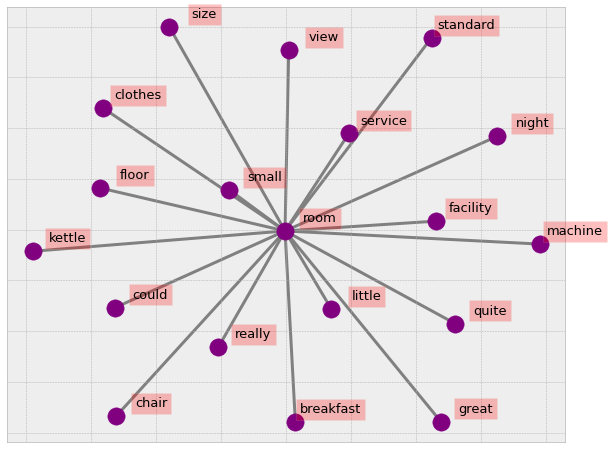

In [43]:
# Create network plot 
G = nx.Graph()

# Create connections between nodes
for k, v in d[0].items():
    G.add_edge(k[0], k[1], weight=(v * 10))

fig, ax = plt.subplots(figsize=(10, 8))

pos = nx.spring_layout(G, k=2)

# Plot networks
nx.draw_networkx(G, pos,
                 font_size=16,
                 width=3,
                 edge_color='grey',
                 node_color='purple',
                 with_labels = False,
                 ax=ax)

# Create offset labels
for key, value in pos.items():
    x, y = value[0]+.135, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=13)
    
plt.show()

In [44]:
## create functions to be utilized for further observation

# Function to create ngrams (for only 1 topics)
def create_ngrams(text_array, n, aspect):
    terms_ngram = [list(ngrams(w,n)) for w in [text_array]]
    ngram = [i for i in terms_ngram[0] if aspect in i]
    return ngram

#create_ngrams(example, 2, aspect = 'room')

def ngrams_flatten(ngram):
    # Flatten list of bigrams in clean tweets
    ngram = list(itertools.chain(*ngram))
    return ngram

# Function to count the frequency
def ngrams_frequency(ngram,  num_most_common):
    ngram_counts = collections.Counter(ngram)
    ngram_df = pd.DataFrame(ngram_counts.most_common(num_most_common),
                             columns=['ngram', 'count'])
    return ngram_df

#ngrams_frequency(create_ngrams(example, 2, aspect = 'room'), 10)

# Create network plot 

def plot_network(dataframe):
    
    try:
        # transform to dict first
        d = dataframe.set_index('ngram').T.to_dict('records')
        d[0]
        G = nx.Graph()

        # Create connections between nodes
        for k, v in d[0].items():
            G.add_edge(k[0], k[1], weight=(v * 10))

        fig, ax = plt.subplots(figsize=(10, 8))
    
        pos = nx.spring_layout(G, k=2)

        # Plot networks
        nx.draw_networkx(G, pos,
                         font_size=16,
                         width=3,
                         edge_color='grey',
                         node_color='purple',
                         with_labels = False,
                         ax=ax)

        # Create offset labels
        for key, value in pos.items():
            x, y = value[0]+.135, value[1]+.045
            ax.text(x, y,
                    s=key,
                    bbox=dict(facecolor='red', alpha=0.25),
                    horizontalalignment='center', fontsize=13)
    
        plt.show()
        
    except:
        return "No Particular Topic"

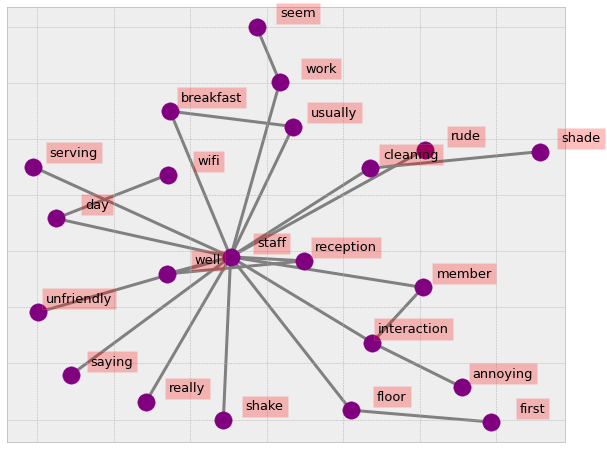

In [45]:
#let's see what they said about staff
plot_network(ngrams_frequency(create_ngrams(example, 3, aspect = 'staff'), 25))

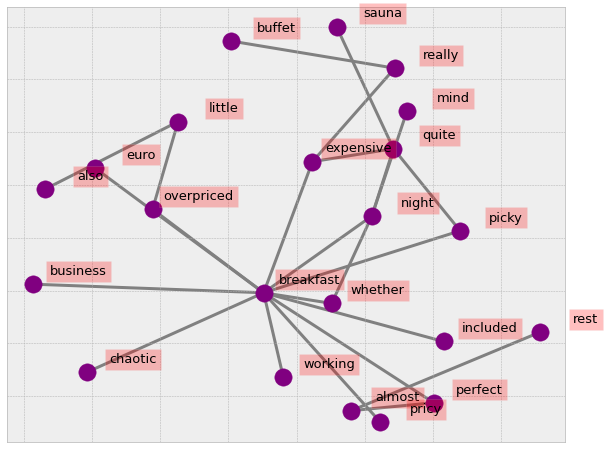

In [46]:
# How about breakfast?
plot_network(ngrams_frequency(create_ngrams(example, 4, aspect = 'breakfast'), 25))

In [47]:
# let's do sentiment analysis for each aspects of each hotels
aspects

['staff',
 'room',
 'breakfast',
 'service',
 'view',
 'restaurant',
 'bathroom',
 'pool']

In [49]:
# Combine the review
df_reviews['Review'] = df_reviews['Negative_Review'] + df_reviews['Positive_Review']

#plot_network(ngrams_frequency(create_ngrams(example, 3, aspect = 'staff'), 25))
# extract each ngrams from each Hotel Reviews based on aspects
from tqdm import tqdm

n = 3
for aspect in tqdm(aspects):
    # create empty list to store sentiment score
    sent_list = []
    for i in df_reviews['Review']:
        # create ngrams
        ngram_i = create_ngrams(i, n, aspect = aspect)
        # flatten ngrams to make clean list
        ngram_flatten_i = ngrams_flatten(ngram_i)
        # Get polarity
        polarity_i = getPolarity(' '.join(ngram_flatten_i))
        sent_list.append(polarity_i)
    
    df_reviews[aspect] = sent_list


100%|██████████| 8/8 [00:54<00:00,  6.79s/it]


In [50]:
df_reviews.head(2)

,Negative_Review,Positive_Review,Review,staff,room,breakfast,service,view,restaurant,bathroom,pool
Hotel_Name,,,,,,,,,,,
11 Cadogan Gardens,"[thought, prise, drink, little, excessive, not...","[particularly, impressed, warm, welcome, recei...","[thought, prise, drink, little, excessive, not...",0.502761,0.202778,0.119945,0.484459,0.177778,0.465476,0.018318,0.0
1K Hotel,"[conditioning, room, work, despite, complainin...","[location, good, close, marais, arrondissement...","[conditioning, room, work, despite, complainin...",0.421448,0.286418,0.104862,0.162868,-0.093750,0.448333,0.332811,0.0


In [51]:
# Normalize sentiment in range of 0 - 10
def normalizeSentiment(x):
    return (x-(-1))/(1+1)*10

In [52]:
df_reviews[aspects] = df_reviews[aspects].apply(normalizeSentiment)

In [53]:
df_reviews.head(2)

,Negative_Review,Positive_Review,Review,staff,room,breakfast,service,view,restaurant,bathroom,pool
Hotel_Name,,,,,,,,,,,
11 Cadogan Gardens,"[thought, prise, drink, little, excessive, not...","[particularly, impressed, warm, welcome, recei...","[thought, prise, drink, little, excessive, not...",7.513805,6.013889,5.599727,7.422297,5.888889,7.327381,5.091588,5.0
1K Hotel,"[conditioning, room, work, despite, complainin...","[location, good, close, marais, arrondissement...","[conditioning, room, work, despite, complainin...",7.107240,6.432088,5.524312,5.814342,4.531250,7.241667,6.664053,5.0


In [182]:
col_df = ['Average_Score', 'Total_Number_of_Reviews','Hotel_Name', 'Hotel_Address','lat','lng']

df_merge = pd.merge(df_reviews, df[col_df].drop_duplicates(), how = 'left', on = 'Hotel_Name')#.drop_duplicates()
df_merge.head(2)

,Hotel_Name,Negative_Review,Positive_Review,Review,staff,room,breakfast,service,view,restaurant,bathroom,pool,Average_Score,Total_Number_of_Reviews,Hotel_Address,lat,lng
0,11 Cadogan Gardens,"[thought, prise, drink, little, excessive, not...","[particularly, impressed, warm, welcome, recei...","[thought, prise, drink, little, excessive, not...",7.513805,6.013889,5.599727,7.422297,5.888889,7.327381,5.091588,5.0,8.7,393,11 Cadogan Gardens Sloane Square Kensington an...,51.493616,-0.159235
1,1K Hotel,"[conditioning, room, work, despite, complainin...","[location, good, close, marais, arrondissement...","[conditioning, room, work, despite, complainin...",7.107240,6.432088,5.524312,5.814342,4.531250,7.241667,6.664053,5.0,7.7,663,13 Boulevard Du Temple 3rd arr 75003 Paris France,48.863932,2.365874


In [183]:
# Function for dashboard

def radar_plot(data): # data categories must be stored as index

    plt.figure(figsize=(10,10))
    # number of variable
    categories=s.index
    N = len(s)
 
    # We are going to plot the first line of the data frame.
    # But we need to repeat the first value to close the circular graph:
    values= s.iloc[:,0].values.flatten().tolist()
    values += values[:1]
    values
 
    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]
 
    # Initialise the spider plot
    ax = plt.subplot(111, polar=True)

    # Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1], categories, color='blue', size=20)
 
    # Draw ylabels
    ax.set_rlabel_position(90)
    plt.yticks([2,4,6,8], ["2","4","6","8"], color="grey", size=20)
    plt.ylim(0,10)
 
    # Plot data
    ax.plot(angles, values, linewidth=2, linestyle='solid')
 
    # Fill area
    ax.fill(angles, values, 'b', alpha=0.1)
    
def plot_coordinate(lat, lng , name , address,  zoom_start = 10, color = 'red', fill_color = 'blue'):   
    m = folium.Map(location=[lat,lng], zoom_start=zoom_start)

    folium.CircleMarker(
            [lat, lng],
            radius=10,
            color=color,
            popup='Name: ' + name[0] + ', Address: ' + address[0],
            fill = True,
            fill_color = fill_color,
            fill_opacity=0.6
        ).add_to(m)
    return m

## Dashboard Ideas

In [185]:
# Search Bar
search = '11 Cadogan Gardens'

search_data = df_merge[df_merge['Hotel_Name'] == search]
search_data

,Hotel_Name,Negative_Review,Positive_Review,Review,staff,room,breakfast,service,view,restaurant,bathroom,pool,Average_Score,Total_Number_of_Reviews,Hotel_Address,lat,lng
0,11 Cadogan Gardens,"[thought, prise, drink, little, excessive, not...","[particularly, impressed, warm, welcome, recei...","[thought, prise, drink, little, excessive, not...",7.513805,6.013889,5.599727,7.422297,5.888889,7.327381,5.091588,5.0,8.7,393,11 Cadogan Gardens Sloane Square Kensington an...,51.493616,-0.159235


In [186]:
# Average Score
search_data['Average_Score'].values[0]

8.7

In [187]:
# Total Number of Reviews
search_data['Total_Number_of_Reviews'].values[0]

393

In [188]:
search_data.Hotel_Name

0    11 Cadogan Gardens
Name: Hotel_Name, dtype: object

In [189]:
plot_coordinate(search_data.lat, search_data.lng, search_data.Hotel_Name, search_data.Hotel_Address, zoom_start = 15)

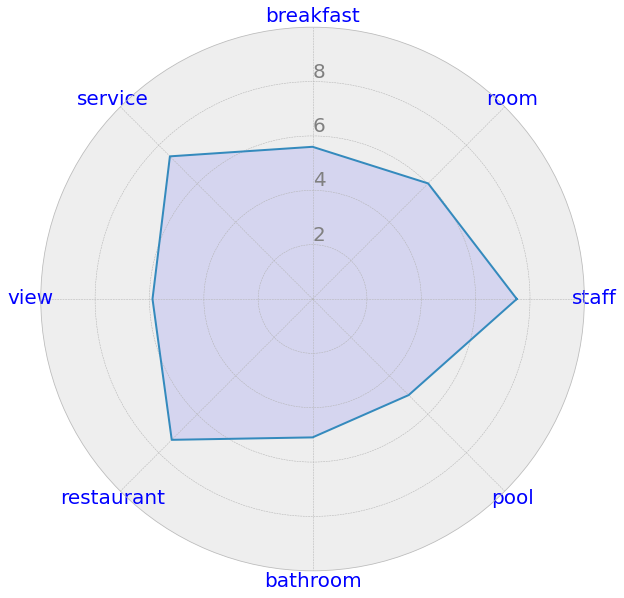

In [190]:
# Sentiment Score

s = search_data[aspects].T
radar_plot(s)

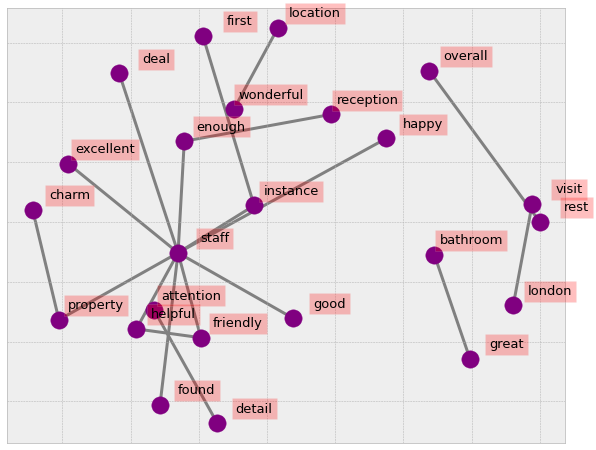

In [191]:
#let's see what they said about staff
plot_network(ngrams_frequency(create_ngrams(search_data['Review'][0], 3, aspect = 'staff'), 20))

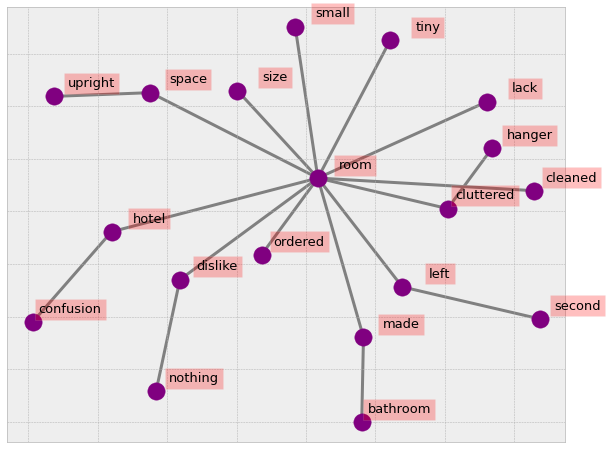

In [192]:
#let's see what they said about room
plot_network(ngrams_frequency(create_ngrams(search_data['Review'][0], 3, aspect = 'room'), 20))

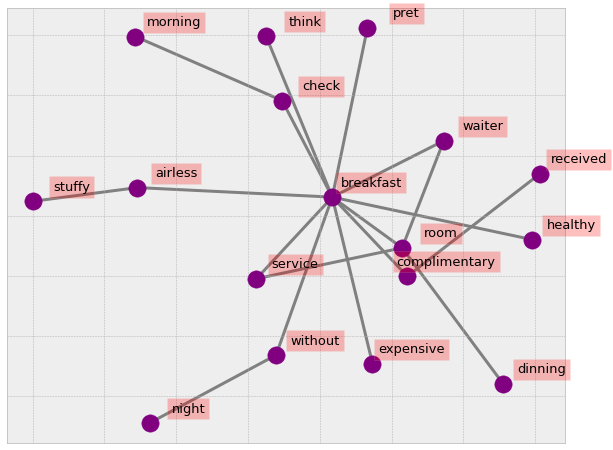

In [193]:
#let's see what they said about breakfast
plot_network(ngrams_frequency(create_ngrams(search_data['Review'][0], 3, aspect = 'breakfast'), 20))

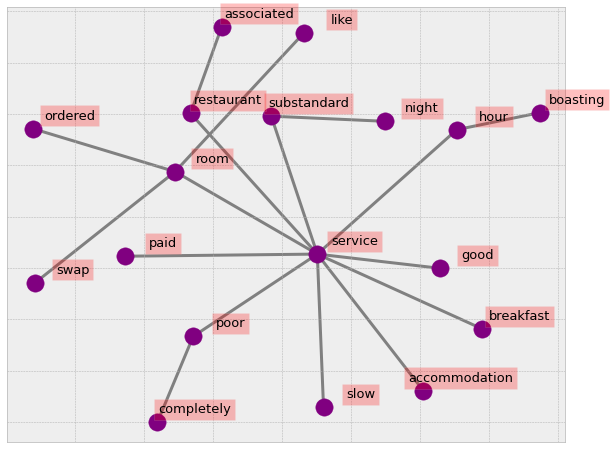

In [194]:
#let's see what they said about service
plot_network(ngrams_frequency(create_ngrams(search_data['Review'][0], 3, aspect = 'service'), 20))

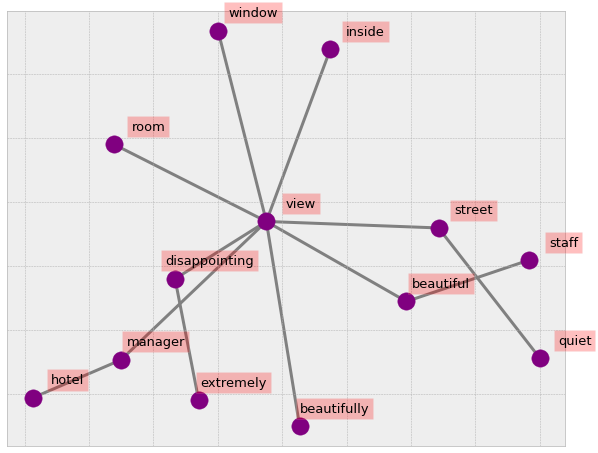

In [195]:
#let's see what they said about view
plot_network(ngrams_frequency(create_ngrams(search_data['Review'][0], 3, aspect = 'view'), 20))

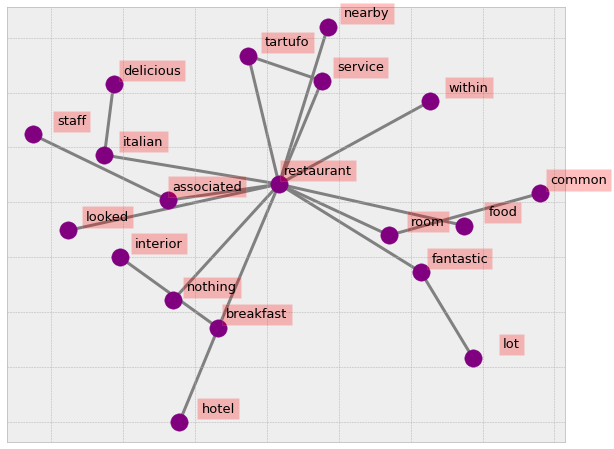

In [197]:
#let's see what they said about restaurant
plot_network(ngrams_frequency(create_ngrams(search_data['Review'][0], 3, aspect = 'restaurant'), 20))

In [198]:
#let's see what they said about pool
plot_network(ngrams_frequency(create_ngrams(search_data['Review'][0], 3, aspect = 'pool'), 20))

'No Particular Topic'

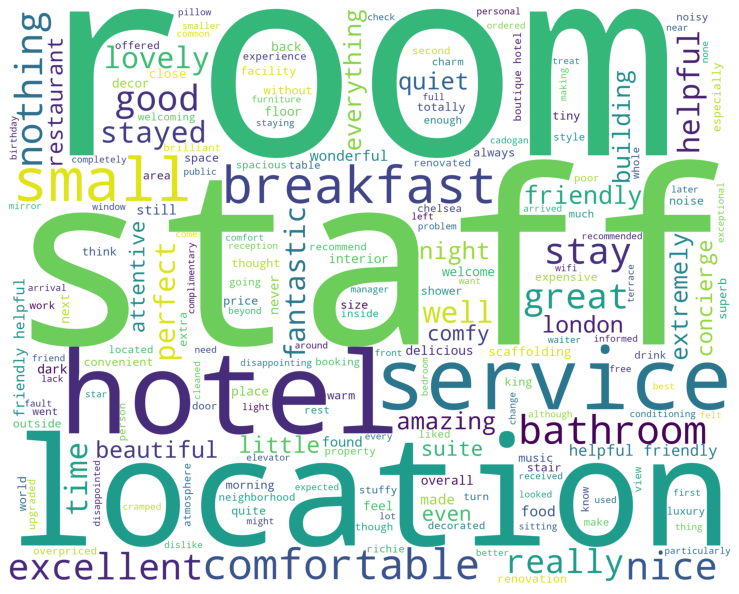

In [199]:
# Draw WordCloud
wordcloud_draw(search_data['Review'][0],'white')